In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
from functools import reduce

from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import datediff, col, lag, avg
from pyspark.sql.window import Window

In [21]:
sp = SparkSession.builder.appName("Loyalty Algo").getOrCreate()
sp

In [22]:
def merge_folder(trans_group: str):
    """
    Function to merge everything within yellow or green or fhvhv
    """
    dir = "../data/tables/" + trans_group +"/"
    folder_locs = os.listdir(dir)

    group_list = []
    for folder in folder_locs:
        path = dir + "/" + folder
        if os.path.isdir(path):
            # print("At current path", path)
            group_list.append(sp.read.parquet(path).sample(0.05))

    return reduce(DataFrame.unionAll, group_list)

In [23]:
dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]

final_list = []
for g in groups:
    print("Started group: ", g)
    final_list.append(sp.read.parquet(dir + g))

final = reduce(DataFrame.unionAll, final_list)

Started group:  transactions_20210228_20210827_snapshot/


Started group:  transactions_20210828_20220227_snapshot/
Started group:  transactions_20220228_20220828_snapshot/


In [24]:
final.count()

14195505

In [25]:
final.show(3)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 3 rows



In [27]:
# Reduce for speed
final = final.sample(0.05)

### Loyalty Formula

RPR * UpSell Ratio * CLV / Rentention period

- RPR : Repeat purchase rate - Number of purchases for a given vendor
- UpSell Ratio: Customers who bought from more than one merchant - Number of varied purchases
- CLV: Customer Lifetime Value - $ value of customer for all purchases / sum of all purchases
- Rentention period: Average number of days between purchases

In [48]:
grouped = final.groupBy("user_id", "merchant_abn")
grouped.count().show(5)

+-------+------------+-----+
|user_id|merchant_abn|count|
+-------+------------+-----+
|   9609| 17758483290|    1|
|  10602| 35040817462|    1|
|  11101| 29639699851|    1|
|  12012| 62204398944|    1|
|  14167| 98268965514|    1|
+-------+------------+-----+
only showing top 5 rows



As seen, there are users that have transacted with more than one merchant. And so we will need to create a loyalty count that is specific to the merchant AND customer, since our goal is to onboard merchants and their customer base

In [60]:
RPR = grouped.count().withColumnRenamed("count", "RPR")
RPR.show(2)

+-------+------------+---+
|user_id|merchant_abn|RPR|
+-------+------------+---+
|   9609| 17758483290|  1|
|  10602| 35040817462|  1|
+-------+------------+---+
only showing top 2 rows



In [61]:
upSell = RPR.groupBy("user_id").count().withColumnRenamed("count", "upsell")
upSell.show(3)

+-------+------+
|user_id|upsell|
+-------+------+
|  13460|    33|
|  23116|    31|
|   5556|    36|
+-------+------+
only showing top 3 rows



In [53]:
CLV = grouped.sum("dollar_value").withColumnRenamed("sum(dollar_value)", "CLV")
CLV.show(3)

+-------+------------+-----------------+
|user_id|merchant_abn|              CLV|
+-------+------------+-----------------+
|   9609| 17758483290|401.7799985768581|
|  10602| 35040817462|342.4804725279166|
|  11101| 29639699851|251.4918691672422|
+-------+------------+-----------------+
only showing top 3 rows



In [34]:
final.show(3)

+-------+------------+-----------------+--------------------+--------------+
|user_id|merchant_abn|     dollar_value|            order_id|order_datetime|
+-------+------------+-----------------+--------------------+--------------+
|  18479| 94493496784|72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
|      4| 49891706470|48.89796461900801|ed11e477-b09f-4ae...|    2021-08-20|
|     11| 82065156333|7.371499545255606|3c6c90bb-2a6e-404...|    2021-08-20|
+-------+------------+-----------------+--------------------+--------------+
only showing top 3 rows



In [54]:
# Define the window
w = Window.partitionBy(["user_id", "merchant_abn"]).orderBy("order_datetime")

retention = final.withColumn(
    'diff',
    datediff(col("order_datetime"), lag("order_datetime").over(w))
).groupBy("user_id", "merchant_abn").agg(avg(col("diff")).alias("retention"))

In [55]:
retention.agg({"retention":"max"}).collect()

[Row(max(retention)=601.0)]

In [64]:
retention.na.fill(value=365).show(3)

+-------+------------+---------+
|user_id|merchant_abn|retention|
+-------+------------+---------+
|      2| 29023134283|    365.0|
|      2| 76646764782|    365.0|
|      2| 78982081666|    365.0|
+-------+------------+---------+
only showing top 3 rows



In [67]:
loyal = retention.na.fill(value=365).join(RPR, on=["user_id", "merchant_abn"], how="left").join(CLV, on=["user_id", "merchant_abn"], how="left").join(upSell, on=["user_id"], how="left")
loyal.show(3)


+-------+------------+---------+---+------------------+------+
|user_id|merchant_abn|retention|RPR|               CLV|upsell|
+-------+------------+---------+---+------------------+------+
|      3| 49891706470|    365.0|  1|10.287366551824753|    29|
|      2| 29023134283|    365.0|  1| 59.87105087146989|    29|
|      2| 76646764782|    365.0|  1|178.76154808867759|    29|
+-------+------------+---------+---+------------------+------+
only showing top 3 rows



In [70]:
loyal = loyal.withColumn(
    "loyal",
    col("RPR") * col("CLV") * col("upSell") / col("retention")
)
loyal.show(3)
loyal.count()

+-------+------------+---------+---+------------------+------+------------------+
|user_id|merchant_abn|retention|RPR|               CLV|upsell|             loyal|
+-------+------------+---------+---+------------------+------+------------------+
|      3| 49891706470|    365.0|  1|10.287366551824753|    29|0.8173524109668983|
|      2| 29023134283|    365.0|  1| 59.87105087146989|    29| 4.756878014445553|
|      2| 76646764782|    365.0|  1|178.76154808867759|    29| 14.20297231389493|
+-------+------------+---------+---+------------------+------+------------------+
only showing top 3 rows



668097

In [75]:
df = loyal.sample(0.05).select("loyal").toPandas()
df.head()

,loyal
0,1.161938
1,15.123564
2,4.478489
3,0.982925
4,1.097052


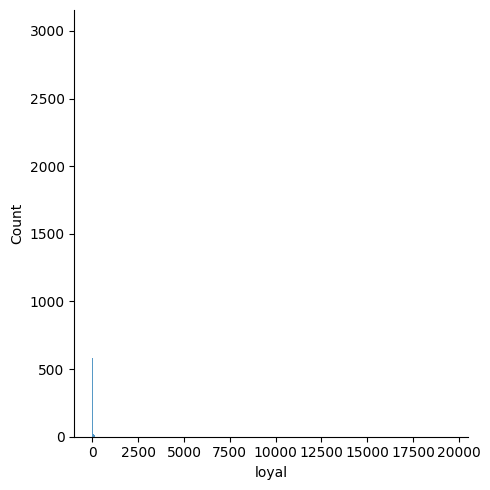

In [76]:
sns.displot(df["loyal"])